Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best Cross-Validated ROC-AUC: 0.7992731565557455

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.55      0.60      4012
           1       0.80      0.86      0.83      8452

    accuracy                           0.76     12464
   macro avg       0.73      0.71      0.72     12464
weighted avg       0.76      0.76      0.76     12464

Test ROC-AUC Score: 0.8059096639329527


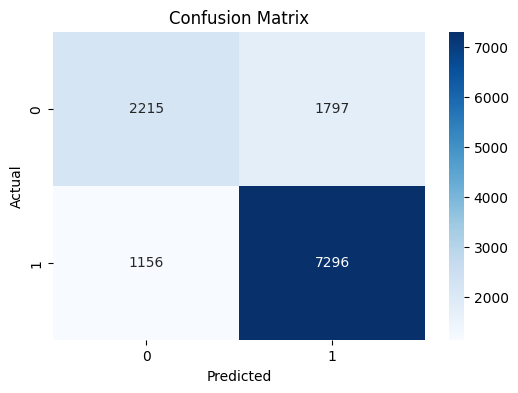


Top 10 Important Features:
                  Feature  Importance
5                loudness    0.084867
2             duration_ms    0.074863
11        energy_loudness    0.067878
10               song_age    0.058172
9                    year    0.058083
14  acoustic_energy_ratio    0.057803
0            acousticness    0.056590
4                liveness    0.055319
8                 valence    0.053924
12          dance_valence    0.053197


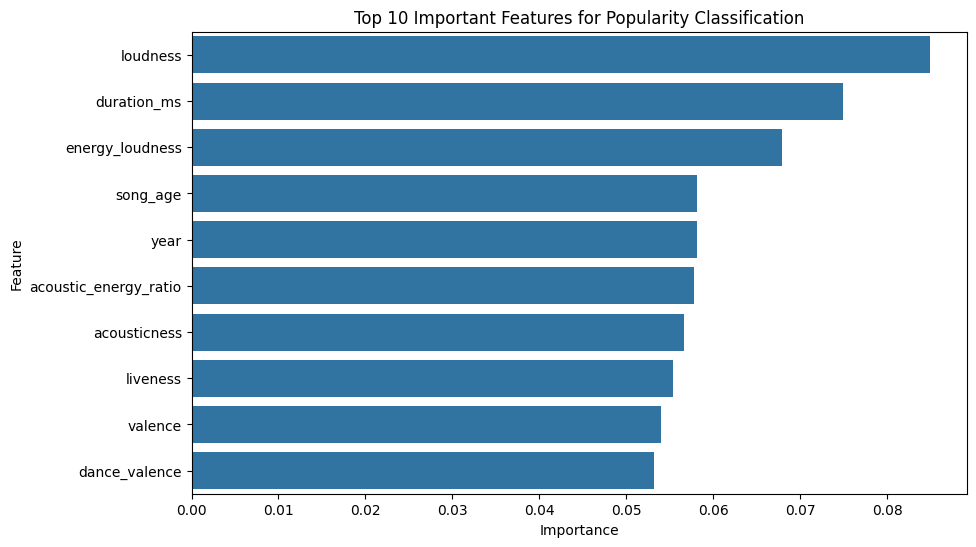

Model saved successfully as spotify_flop_classifier.pkl


In [1]:
# ==============================
# 1. Import Libraries
# ==============================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns


# ==============================
# 2. Load Dataset
# ==============================

df = pd.read_csv("spotify_tracks.csv")


# ==============================
# 3. Drop Unnecessary Columns
# ==============================

df = df.drop(columns=[
    "track_id",
    "track_name",
    "artist_name",
    "artwork_url",
    "album_name",
    "track_url"
])


# ==============================
# 4. Handle Missing Values
# ==============================

df = df.dropna()


# ==============================
# 5. Feature Engineering
# ==============================

current_year = df["year"].max()

df["song_age"] = current_year - df["year"]
df["energy_loudness"] = df["energy"] * df["loudness"]
df["dance_valence"] = df["danceability"] * df["valence"]
df["speech_energy"] = df["speechiness"] * df["energy"]
df["acoustic_energy_ratio"] = df["acousticness"] / (df["energy"] + 1e-5)
df["tempo_energy"] = df["tempo"] * df["energy"]


# ==============================
# 6. Convert Popularity to Classification
# ==============================

df["flop_class"] = (df["popularity"] < 20).astype(int)
df = df.drop("popularity", axis=1)


# ==============================
# 7. Define Features and Target
# ==============================

X = df.drop("flop_class", axis=1)
y = df["flop_class"]


# ==============================
# 8. Identify Column Types
# ==============================

num_cols = [
    "acousticness", "danceability", "duration_ms",
    "energy", "liveness", "loudness",
    "speechiness", "tempo",
    "valence", "year",
    "song_age", "energy_loudness",
    "dance_valence", "speech_energy",
    "acoustic_energy_ratio", "tempo_energy"
]

cat_cols = ["language"]


# ==============================
# 9. Train-Test Split (BEFORE GridSearch)
# ==============================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ==============================
# 10. Preprocessing Pipeline
# ==============================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)


# ==============================
# 11. Build Model Pipeline
# ==============================

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])


# ==============================
# 12. Hyperparameter Grid
# ==============================

param_grid = {
    "classifier__n_estimators": [200, 300],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2]
}


# ==============================
# 13. GridSearch with CV (ONLY TRAIN DATA)
# ==============================

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

print("Best Cross-Validated ROC-AUC:", grid_search.best_score_)


# ==============================
# 14. Evaluate on Test Set
# ==============================

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("Test ROC-AUC Score:", roc_auc)


# ==============================
# 15. Confusion Matrix
# ==============================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ==============================
# 16. Feature Importance
# ==============================

ohe = best_model.named_steps["preprocessing"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

all_features = num_cols + list(encoded_cat_cols)

importances = best_model.named_steps["classifier"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


# ==============================
# 17. Plot Feature Importance
# ==============================

plt.figure(figsize=(10,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.head(10)
)
plt.title("Top 10 Important Features for Popularity Classification")
plt.show()
# ==============================
# 18. Save Model to Disk
# ==============================

import joblib

# Save the entire pipeline (preprocessing + classifier)
joblib.dump(best_model, "spotify_flop_classifier.pkl")

print("Model saved successfully as spotify_flop_classifier.pkl")


In [3]:
import pandas as pd
df = pd.read_csv("spotify_tracks.csv")
df["language"].value_counts()

language
English      23392
Unknown      13005
Tamil        12681
Korean        6893
Hindi         5740
Telugu         324
Malayalam      282
Name: count, dtype: int64

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best Cross-Validated ROC-AUC: 0.7993560026019073

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.54      0.60      4012
           1       0.80      0.87      0.83      8452

    accuracy                           0.76     12464
   macro avg       0.73      0.71      0.71     12464
weighted avg       0.75      0.76      0.76     12464

Test ROC-AUC Score: 0.8066468188902294


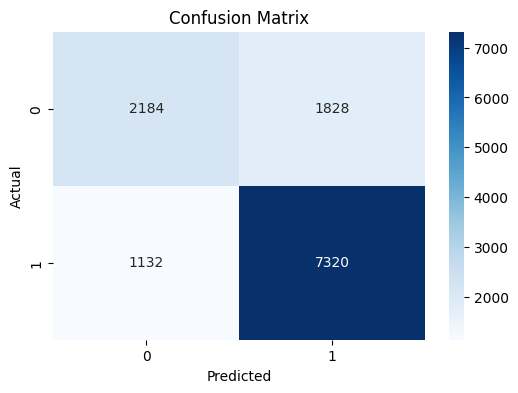


Top 10 Important Features:
                  Feature  Importance
5                loudness    0.083289
2             duration_ms    0.073849
11        energy_loudness    0.068774
10               song_age    0.058241
9                    year    0.058084
0            acousticness    0.056901
14  acoustic_energy_ratio    0.056670
4                liveness    0.055669
3                  energy    0.054271
8                 valence    0.054202


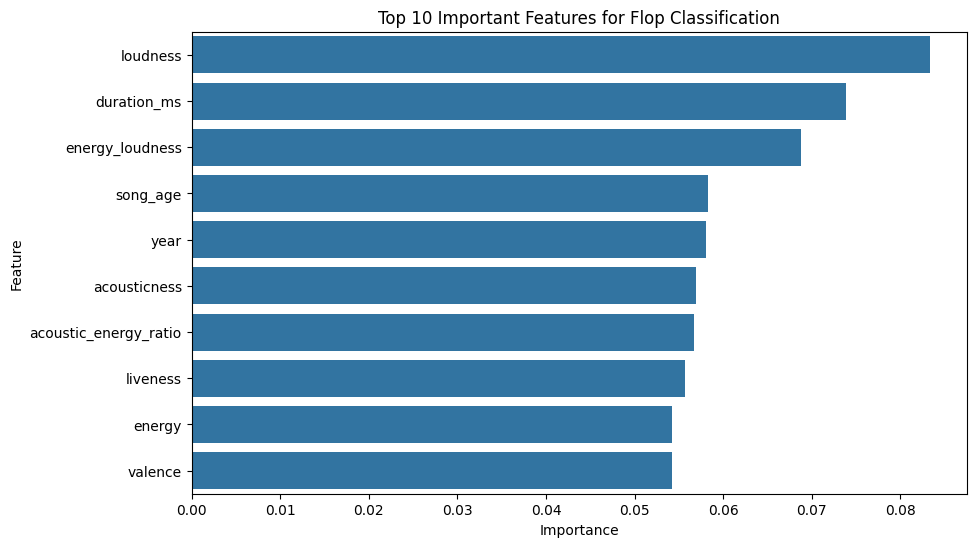

Model saved successfully as spotify_flop2_classifier.pkl


In [4]:
# ==============================
# 1. Import Libraries
# ==============================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# ==============================
# 2. Load Dataset
# ==============================

df = pd.read_csv("spotify_tracks.csv")


# ==============================
# 3. Drop Unnecessary Columns
# ==============================

df = df.drop(columns=[
    "track_id",
    "track_name",
    "artist_name",
    "artwork_url",
    "album_name",
    "track_url"
])


# ==============================
# 4. Handle Missing Values
# ==============================

df = df.dropna()


# ==============================
# 5. Language Grouping (Improved)
# ==============================

df["language"] = df["language"].replace({
    "Telugu": "Other",
    "Malayalam": "Other",
    "Unknown": "Other"
})

# Final categories:
# English, Korean, Hindi, Tamil, Other


# ==============================
# 6. Feature Engineering
# ==============================

current_year = df["year"].max()

df["song_age"] = current_year - df["year"]
df["energy_loudness"] = df["energy"] * df["loudness"]
df["dance_valence"] = df["danceability"] * df["valence"]
df["speech_energy"] = df["speechiness"] * df["energy"]
df["acoustic_energy_ratio"] = df["acousticness"] / (df["energy"] + 1e-5)
df["tempo_energy"] = df["tempo"] * df["energy"]


# ==============================
# 7. Convert Popularity to Classification
# ==============================

df["flop_class"] = (df["popularity"] < 20).astype(int)
df = df.drop("popularity", axis=1)


# ==============================
# 8. Define Features and Target
# ==============================

X = df.drop("flop_class", axis=1)
y = df["flop_class"]


# ==============================
# 9. Identify Column Types
# ==============================

num_cols = [
    "acousticness", "danceability", "duration_ms",
    "energy", "liveness", "loudness",
    "speechiness", "tempo",
    "valence", "year",
    "song_age", "energy_loudness",
    "dance_valence", "speech_energy",
    "acoustic_energy_ratio", "tempo_energy"
]

cat_cols = ["language"]


# ==============================
# 10. Train-Test Split
# ==============================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ==============================
# 11. Preprocessing Pipeline
# ==============================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(
            drop="first",
            handle_unknown="ignore"  # Important for Streamlit
        ), cat_cols)
    ]
)


# ==============================
# 12. Build Model Pipeline
# ==============================

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])


# ==============================
# 13. Hyperparameter Grid
# ==============================

param_grid = {
    "classifier__n_estimators": [200, 300],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2]
}


# ==============================
# 14. GridSearchCV
# ==============================

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)
print("Best Cross-Validated ROC-AUC:", grid_search.best_score_)


# ==============================
# 15. Evaluate on Test Set
# ==============================

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("Test ROC-AUC Score:", roc_auc)


# ==============================
# 16. Confusion Matrix
# ==============================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ==============================
# 17. Feature Importance
# ==============================

# Get encoded categorical column names
ohe = best_model.named_steps["preprocessing"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

all_features = num_cols + list(encoded_cat_cols)

importances = best_model.named_steps["classifier"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


# ==============================
# 18. Plot Feature Importance
# ==============================

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.head(10)
)
plt.title("Top 10 Important Features for Flop Classification")
plt.show()


# ==============================
# 19. Save Model
# ==============================

joblib.dump(best_model, "spotify_flop_classifier.pkl")

print("Model saved successfully as spotify_flop2_classifier.pkl")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best Cross-Validated ROC-AUC: 0.7995597715670275

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.54      0.60      4012
           1       0.80      0.87      0.83      8452

    accuracy                           0.76     12464
   macro avg       0.73      0.71      0.71     12464
weighted avg       0.75      0.76      0.76     12464

Test ROC-AUC Score: 0.80637690867294


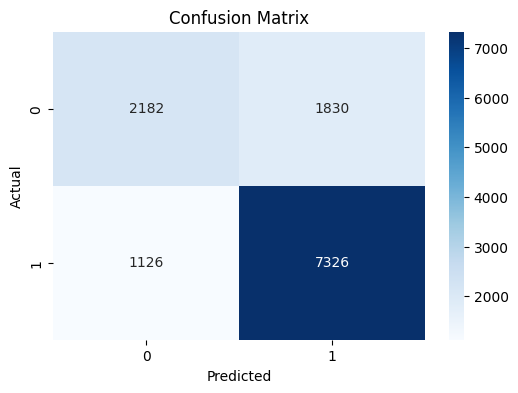


Top 10 Important Features:
                  Feature  Importance
5                loudness    0.083606
2             duration_ms    0.074342
11        energy_loudness    0.069099
10               song_age    0.058511
9                    year    0.057629
14  acoustic_energy_ratio    0.057033
4                liveness    0.056101
0            acousticness    0.055699
8                 valence    0.053633
3                  energy    0.053490


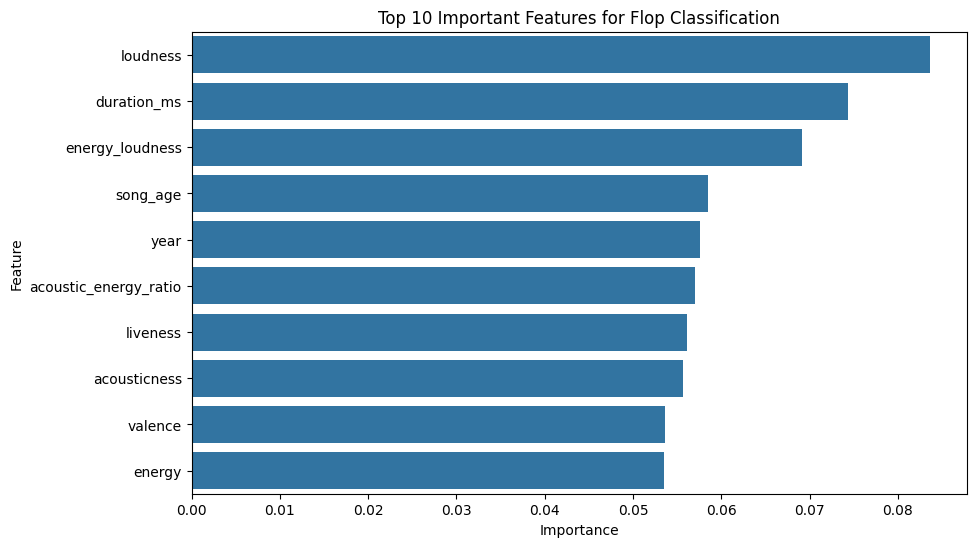

Model saved successfully as spotify_flop2_classifier.pkl


In [5]:
# ==============================
# 1. Import Libraries
# ==============================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# ==============================
# 2. Load Dataset
# ==============================

df = pd.read_csv("spotify_tracks.csv")


# ==============================
# 3. Drop Unnecessary Columns
# ==============================

df = df.drop(columns=[
    "track_id",
    "track_name",
    "artist_name",
    "artwork_url",
    "album_name",
    "track_url"
])


# ==============================
# 4. Handle Missing Values
# ==============================

df = df.dropna()


# ==============================
# 5. Language Grouping (Improved)
# ==============================

df["language"] = df["language"].replace({
    "Telugu": "Regional",
    "Malayalam": "Regional",
    "Tamil":"Regional",
    "Unknown": "Other"
})

# Final categories:
# English, Korean, Hindi, Tamil, Other


# ==============================
# 6. Feature Engineering
# ==============================

current_year = df["year"].max()

df["song_age"] = current_year - df["year"]
df["energy_loudness"] = df["energy"] * df["loudness"]
df["dance_valence"] = df["danceability"] * df["valence"]
df["speech_energy"] = df["speechiness"] * df["energy"]
df["acoustic_energy_ratio"] = df["acousticness"] / (df["energy"] + 1e-5)
df["tempo_energy"] = df["tempo"] * df["energy"]


# ==============================
# 7. Convert Popularity to Classification
# ==============================

df["flop_class"] = (df["popularity"] < 20).astype(int)
df = df.drop("popularity", axis=1)


# ==============================
# 8. Define Features and Target
# ==============================

X = df.drop("flop_class", axis=1)
y = df["flop_class"]


# ==============================
# 9. Identify Column Types
# ==============================

num_cols = [
    "acousticness", "danceability", "duration_ms",
    "energy", "liveness", "loudness",
    "speechiness", "tempo",
    "valence", "year",
    "song_age", "energy_loudness",
    "dance_valence", "speech_energy",
    "acoustic_energy_ratio", "tempo_energy"
]

cat_cols = ["language"]


# ==============================
# 10. Train-Test Split
# ==============================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ==============================
# 11. Preprocessing Pipeline
# ==============================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(
            drop="first",
            handle_unknown="ignore"  # Important for Streamlit
        ), cat_cols)
    ]
)


# ==============================
# 12. Build Model Pipeline
# ==============================

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])


# ==============================
# 13. Hyperparameter Grid
# ==============================

param_grid = {
    "classifier__n_estimators": [200, 300],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2]
}


# ==============================
# 14. GridSearchCV
# ==============================

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)
print("Best Cross-Validated ROC-AUC:", grid_search.best_score_)


# ==============================
# 15. Evaluate on Test Set
# ==============================

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("Test ROC-AUC Score:", roc_auc)


# ==============================
# 16. Confusion Matrix
# ==============================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ==============================
# 17. Feature Importance
# ==============================

# Get encoded categorical column names
ohe = best_model.named_steps["preprocessing"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

all_features = num_cols + list(encoded_cat_cols)

importances = best_model.named_steps["classifier"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


# ==============================
# 18. Plot Feature Importance
# ==============================

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.head(10)
)
plt.title("Top 10 Important Features for Flop Classification")
plt.show()


# ==============================
# 19. Save Model
# ==============================

joblib.dump(best_model, "spotify_flop_classifier.pkl")

print("Model saved successfully as spotify_flop2_classifier.pkl")
